In [1]:
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
from concurrent import futures
import numpy as np
import pandas_datareader.data as web
from scipy.stats import gaussian_kde
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster, set_link_color_palette
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
data_dir = "./data/stock_data_for_clustering"
os.makedirs(data_dir, exist_ok=True)

In [3]:
tables = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
first_table = tables[0]
print(first_table.shape)
first_table["Symbol"] = first_table["Symbol"].map(lambda x: x.replace(".", "-"))  # rename symbol to escape symbol error
sp500_tickers = list(first_table["Symbol"])
first_table.head()

(504, 9)


,Symbol,Security,SEC filings,GICS Sector,GICS Sub-Industry,Headquarters Location,Date first added,CIK,Founded
0,MMM,3M,reports,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1976-08-09,66740,1902
1,AOS,A. O. Smith,reports,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
2,ABT,Abbott,reports,Health Care,Health Care Equipment,"North Chicago, Illinois",1964-03-31,1800,1888
3,ABBV,AbbVie,reports,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
4,ABMD,Abiomed,reports,Health Care,Health Care Equipment,"Danvers, Massachusetts",2018-05-31,815094,1981


In [4]:
def download_stock(stock):
    try:
        print(stock)
        stock_df = web.DataReader(stock,'yahoo', start_time, end_time)
        stock_df['Name'] = stock
        output_name = f"{data_dir}/{stock}.csv"
        stock_df.to_csv(output_name)
    except:
        bad_names.append(stock)
        print('bad: %s' % (stock))
""" set the download window """
start_time = dt.datetime(2021, 12, 1)
end_time = dt.datetime(2022, 3, 1)
bad_names =[] #to keep track of failed queries
#set the maximum thread number
max_workers = 20
now = dt.datetime.now()
workers = min(max_workers, len(sp500_tickers)) #in case a smaller number of stocks than threads was passed in
with futures.ThreadPoolExecutor(workers) as executor:
    res = executor.map(download_stock, sp500_tickers)
""" Save failed queries to a text file to retry """
if len(bad_names) > 0:
    with open(f'{data_dir}/failed_queries.txt','w') as outfile:
        for name in bad_names:
            outfile.write(name+'\n')
finish_time = dt.datetime.now()
duration = finish_time - now
minutes, seconds = divmod(duration.seconds, 60)
print(f'The threaded script took {minutes} minutes and {seconds} seconds to run.')
print(f"{len(bad_names)} stocks failed: ", bad_names)

MMMAOS
ABT

ABBV
ABMD
ACN
ATVI
ADM
ADBE
ADP
AAP
AES
AFL
A
AIG
APD
AKAM
ALK
ALB
ARE
ALGNALLE
LNT

ALLGOOGL

GOOG
MO
AMZN
AMCR
AMD
AEEAAL
AEP

AXPAMT

AWK
AMP
ABC
AME
AMGN
APH
ADI
ANSS
ANTM
AON
APA
AAPL
AMAT
APTV
ANET
AIZ
T
ATO
ADSK
AZOAVBAVY


BKR
BALL
BAC
BBWI
BAX
BDX
WRB
BRK-B
BBY
BIO
TECH
BIIB
BLKBKBA


BKNG
BWA
BXP
BSX
BMY
AVGO
BR
BRO
BF-B
CHRW
CDNS
CZR
CPT
CPB
COF
CAH
KMX
CCL
CARRCTLT

CATCBOE
CBRE

CDW
CECNC
CNP

CDAYCF
CRL

SCHWCHTR

CVX
CMG
CB
CHD
CICINF

CTASCSCO

C
CFG
CTXS
CLX
CME
CMS
KO
CTSH
CL
CMCSA
CMA
CAGCOP

EDSTZ
CEGCOO

CPRT
GLW
CTVA

COST
CTRACCI

CSX
CMI
CVS
DHI
DHR
DRI
DVA
DE
DALXRAY

DVN
DXCM
FANGDLR

DFSDISH

DIS
DG
DLTRD

DPZ
DOV
DOWDTEDUKDRE



DDDXC

EMN
ETN
EBAY
ECL
EIX
EW
EA
EMRENPH
ETR
EOGEPAM


EFXEQIX

EQR
ESS
ELETSY

RE
EVRG
ES
EXC
EXPE
EXPDEXR
XOM

FFIV
FDS
FAST
FRTFDXFITB


FRC
FE
FIS
FISV
FLT
FMC
F
FTNT
FTV
FBHS
FOXA
FOX
BEN
FCX
AJG
GRMN
ITGE

GNRC
GD
GISGPC

GILDGL
GPN

GM
GS
GWW
HALHIG

HAS
HCA
PEAK
HSIC
HSY
HES
HPE
HLT
HOLX
HD
HON
HRL
HST
HWMHPQ

HU

In [5]:
historical_stock_data_files = glob.glob(f"./{data_dir}/*.csv")
reference_day = "2021-12-31"
start_day = "2022-01-03"
midterm_day = "2022-01-18"
end_day = "2022-01-31"
price_change_list = []
tickers_to_ignore = []
for files in historical_stock_data_files:
    df = pd.read_csv(files, index_col=["Date"])
    ticker = os.path.splitext(os.path.basename(files))[0]
    try:
        price_close = df[reference_day: end_day][["Close"]]
        price_change = (price_close / price_close.loc[reference_day, "Close"] - 1) * 100
        price_change = price_change.iloc[1: ,:]
        price_change = price_change.rename(columns={"Close": ticker})
        price_change_list.append(price_change)
    except KeyError as e:
        # some stocks started trading after 2021-12-31
        print(ticker)
        tickers_to_ignore.append(ticker)
    
df = pd.concat(price_change_list, axis=1)
print(df.shape)
df.head()

CEG
(20, 503)


,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2022-01-03,-1.985592,4.398669,-1.292315,2.500415,0.014774,-0.203179,1.982347,-1.207910,-1.770594,-0.474377,...,3.210249,0.354513,3.840501,1.971677,-2.526683,-1.677950,1.645153,-1.898519,1.709940,-4.097857
2022-01-04,-5.299087,5.902012,-1.179757,1.199521,-0.177245,-1.151327,0.673771,-3.531335,-2.472561,-2.303107,...,2.880994,0.989669,7.746367,2.491485,-1.492663,-1.152244,2.676323,-1.276888,4.607346,-7.749049
2022-01-05,-6.921383,4.008916,-1.429885,-1.492374,0.347121,-0.293475,-5.838461,-3.964759,-4.190085,-9.281206,...,-0.928976,1.979326,9.086454,0.842440,-2.835225,-2.405298,2.337850,-6.219761,4.844841,-11.256813
2022-01-06,-6.595678,3.396440,0.737864,-3.136795,-0.125553,-1.836107,-6.328482,-3.978972,-8.816787,-9.335873,...,-0.470369,1.181688,11.652233,0.770748,-2.968644,-1.397092,1.487722,-6.727157,9.151366,-10.904397
2022-01-07,-9.082368,7.349675,-0.746210,-3.041059,-0.384039,0.173072,-11.106165,-3.680551,-10.565671,-9.938981,...,-0.576197,2.067949,12.567411,1.093387,-3.744161,-2.527722,0.873738,-10.809816,10.972129,-13.498341


In [6]:
data_1 = df.loc[[end_day], :]
display(data_1.head())
data_2 = df.loc[[start_day, midterm_day, end_day], :]
display(data_2.head())
data_3 = df
display(data_3.head())

,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2022-01-31,-12.734098,-8.296213,-3.489249,-1.571216,1.100447,2.49078,-17.623971,-9.435843,-14.707515,-5.777168,...,0.482121,2.895136,24.137932,-4.248078,-12.424951,-9.858852,-3.16436,-14.462368,7.378087,-18.128921


,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2022-01-03,-1.985592,4.398669,-1.292315,2.500415,0.014774,-0.203179,1.982347,-1.207910,-1.770594,-0.474377,...,3.210249,0.354513,3.840501,1.971677,-2.526683,-1.677950,1.645153,-1.898519,1.709940,-4.097857
2022-01-18,-12.013776,-0.334073,-0.821244,-4.375741,1.019206,0.692301,-18.595653,-10.068215,-15.986007,-9.473419,...,7.114294,1.019206,19.431285,-4.714108,-8.288855,-8.987472,-0.543133,-13.185491,9.927170,-16.936443
2022-01-31,-12.734098,-8.296213,-3.489249,-1.571216,1.100447,2.490780,-17.623971,-9.435843,-14.707515,-5.777168,...,0.482121,2.895136,24.137932,-4.248078,-12.424951,-9.858852,-3.164360,-14.462368,7.378087,-18.128921


,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2022-01-03,-1.985592,4.398669,-1.292315,2.500415,0.014774,-0.203179,1.982347,-1.207910,-1.770594,-0.474377,...,3.210249,0.354513,3.840501,1.971677,-2.526683,-1.677950,1.645153,-1.898519,1.709940,-4.097857
2022-01-04,-5.299087,5.902012,-1.179757,1.199521,-0.177245,-1.151327,0.673771,-3.531335,-2.472561,-2.303107,...,2.880994,0.989669,7.746367,2.491485,-1.492663,-1.152244,2.676323,-1.276888,4.607346,-7.749049
2022-01-05,-6.921383,4.008916,-1.429885,-1.492374,0.347121,-0.293475,-5.838461,-3.964759,-4.190085,-9.281206,...,-0.928976,1.979326,9.086454,0.842440,-2.835225,-2.405298,2.337850,-6.219761,4.844841,-11.256813
2022-01-06,-6.595678,3.396440,0.737864,-3.136795,-0.125553,-1.836107,-6.328482,-3.978972,-8.816787,-9.335873,...,-0.470369,1.181688,11.652233,0.770748,-2.968644,-1.397092,1.487722,-6.727157,9.151366,-10.904397
2022-01-07,-9.082368,7.349675,-0.746210,-3.041059,-0.384039,0.173072,-11.106165,-3.680551,-10.565671,-9.938981,...,-0.576197,2.067949,12.567411,1.093387,-3.744161,-2.527722,0.873738,-10.809816,10.972129,-13.498341


Exploratory Data Analysis(EDA)
January is usually a month when the market tends to rise, but January 2022 was a difficult month. Here is a quick analysis of how stocks performed.

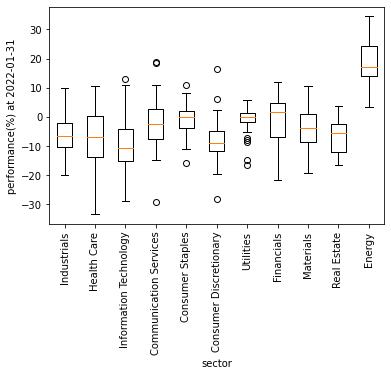

In [7]:
first_table = first_table[~first_table["Symbol"].isin(tickers_to_ignore)]
industry_list = list(first_table["GICS Sector"].unique())
performance_by_industry = [data_1.loc[:, first_table[first_table["GICS Sector"]==x]["Symbol"]].values[0] for x in industry_list]
plt.boxplot(performance_by_industry, labels=industry_list)
plt.xticks(rotation=90)
plt.xlabel("sector")
plt.ylabel(f"performance(%) at {end_day}")
plt.show()

### Clustering
One-dimentional data
We will first perform clustering using Type 1 data.

Before clustering, we first check the distribution of the data

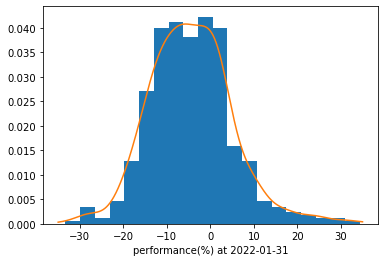

In [8]:
# Kernel density estimation
x = np.linspace(-35, 35, 1000)
kde = gaussian_kde(data_1.values)
y = kde(x)
plt.hist(data_1.loc[end_day, :], bins=20, density=True)
plt.plot(x, y)
plt.xlabel(f"performance(%) at {end_day}")
plt.show()

You don’t think clustering is particularly necessary because the data is nicely distributed around -5 and there is no cluster.

If you dare to do clustering, you can, for example, arbitrarily divide the data into clusters smaller than 0 and clusters greater than 0.

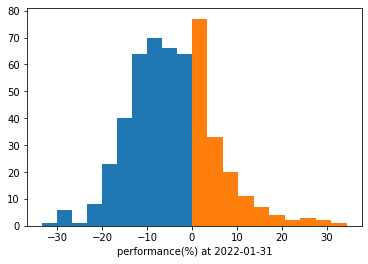

In [9]:
plt.hist(data_1[data_1 < 0].loc[end_day, :], bins=10)
plt.hist(data_1[data_1 >= 0].loc[end_day, :], bins=10)
plt.xlabel(f"performance(%) at {end_day}")
plt.show()

Here we will use KMeans clustering to divide the data into three clusters as a test. We could indeed divide them into three, but the boundaries of the clusters are not appropriate.

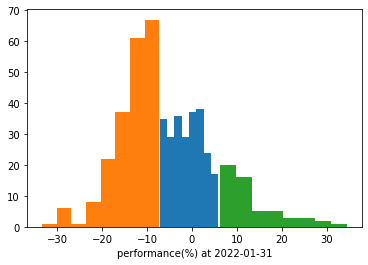

In [10]:
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(data_1.T.values)
for i in range(n_clusters):
    plt.hist(data_1.loc[end_day, kmeans.labels_ == i], bins=8)
plt.xlabel(f"performance(%) at {end_day}")
plt.show()

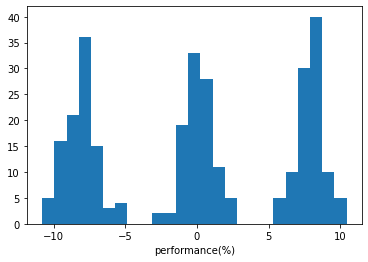

In [11]:
dummy_zero = np.random.normal(0,1,100)
dummy_minus = np.random.normal(-8,1,100)
dummy_plus = np.random.normal(8,1,100)
dummy = np.concatenate([dummy_zero, dummy_minus, dummy_plus])
plt.hist(dummy, bins=25)
plt.xlabel("performance(%)")
plt.show()

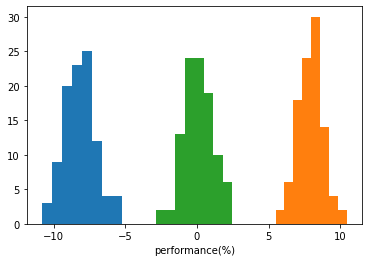

In [12]:
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(dummy.reshape(-1,1))
for i in range(n_clusters):
    plt.hist(dummy[kmeans.labels_ == i], bins=8)
plt.xlabel("performance(%)")
plt.show()

Two-dimentional data
What if the data is two-dimensional? The distribution of the data becomes a bit more complex.

Let’s check the distribution of type 2 data.

Note that type 2 data has three dimensions. So we are going to slice the data and plot the two-dimensional data.

We first plot performance on January 18 and January 31.

In [16]:
def scatter_hist(x, y, ax, ax_histx, ax_histy):
    # no labels
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)
# the scatter plot:
    ax.scatter(x, y, alpha=0.5)

In [18]:
# now determine nice limits by hand:
binwidth = 0.25
xymax = max(np.max(np.abs(x)), np.max(np.abs(y)))
lim = (int(xymax/binwidth) + 1) * binwidth